#%% [markdown]

  # Importowanie bibliotek

In [ ]:
import numpy as np
from sklearn.datasets import make_classification,make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

#%% [markdown]

 # Przygotowanie próbek

In [ ]:
iterations=100
X,t=make_classification(n_samples=2579,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=1,random_state=254479)
X_moons,t_moons=make_moons(n_samples=2579,random_state=254479)
X_train,X_test,y_train,y_test=train_test_split(X,t)
X_train_moons,X_test_moons,y_train_moons,y_test_moons=train_test_split(X_moons,t_moons)
#Standaryzacja
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train_moons=scaler.fit_transform(X_train_moons)
X_test_moons=scaler.transform(X_test_moons)


def log_classifier_time(func): #Dekorator do mierzenia czasu klasyfikowania 
    def wrapper(*args,**kwargs):
        start_time=time.time()
        for _ in range(iterations):
            result=func(*args,**kwargs)
        end_time=time.time()-start_time
        print(f"Czas wykonywania {iterations} iteracji wyniósł {end_time:.6f} sekund")
        return result
    return wrapper
def display_classifier_details(y_pred,y_test,name):
    tn, fp, fn, tp=confusion_matrix(y_test,y_pred).ravel()
    sensitivity=tp/(tp+fp)
    specificity=tn/(tn+fn)

    print(f"""\t{name}\n
          \taccuracy: {accuracy_score(y_test,y_pred)}\n
          \tsensitivity: {sensitivity}\n
          \tspecificity: {specificity}
        """)
def plot_roc_curve(y_test,y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'Krzywa ROC - AUC={roc_auc}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.title("Krzywa ROC")
    plt.show()
def plot_decision_boundary(X_test,y_test,clf,title="",pandas=False):
    if not pandas:
        x_min,x_max=X_test[:,0].min(),X_test[:,0].max()
        y_min,y_max=X_test[:,1].min(),X_test[:,1].max()
    else:
        x_min,x_max=X_test.iloc[:,0].min(),X_test.iloc[:,0].max()
        y_min,y_max=X_test.iloc[:,1].min(),X_test.iloc[:,1].max()
    num=1000
    xx,yy=np.meshgrid(np.linspace(x_min,x_max,num),np.linspace(y_min,y_max,num))

    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape((num,num))
    plt.title(title)
    plt.contourf(xx,yy,Z)
    plt.scatter(X_test[:,0],X_test[:,1],c=y_test,edgecolors="black")
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

#%% [markdown]

 # Zadanie na 3 - własna implementacja neuronu
 # Syntetyczny zbiór jednomodowy

	Własna implementacja neuronu - funkcja logistyczna

          	accuracy: 0.8325581395348837

          	sensitivity: 0.8327759197324415

          	specificity: 0.8323699421965318
        


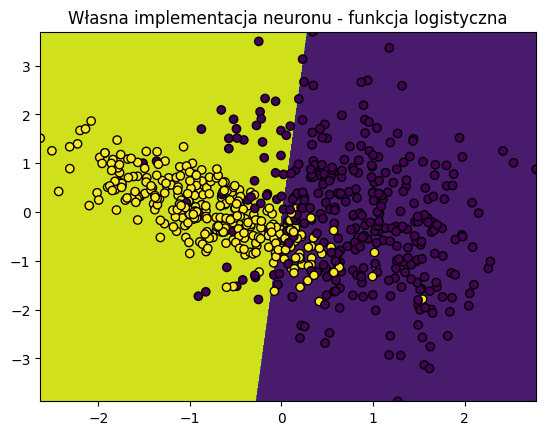

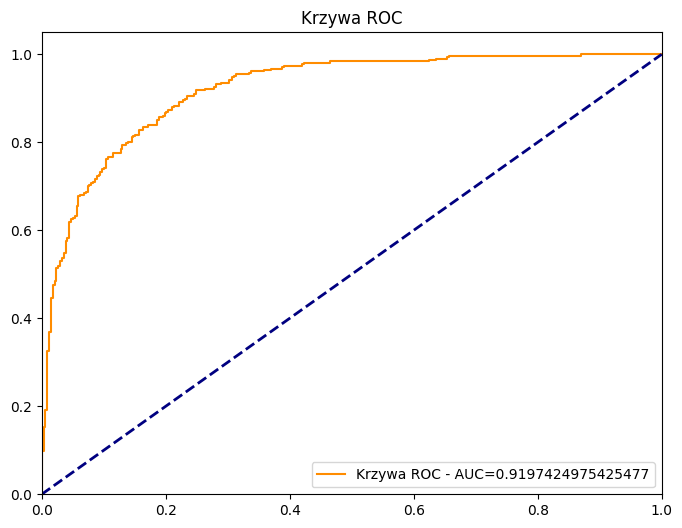

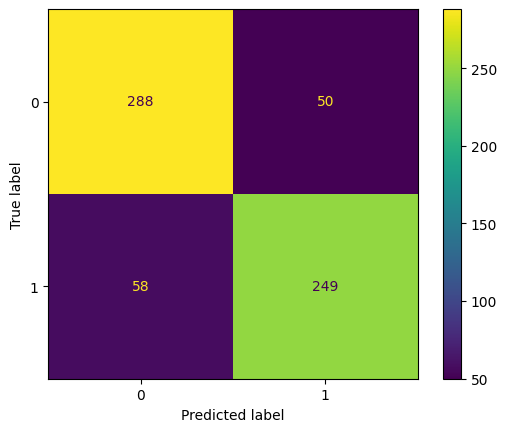

Czas uczenia 0.0368955135345459 s


In [ ]:
from enum import Enum
class ActivationFunction(Enum):
    SIGMOID="sigmoid"
    TANH="tanh"
    RELU="relu"
    SIGN="sign"
    LEAKY="leaky"
    HEAVISIDE="heaviside"
    SIN="sin"

class Neuron:#Własna implementacja neuronu
    def __init__(self,max_iter=1000,tol=1e-7,batch=False,batch_size=20,type=ActivationFunction.SIGMOID) -> None:
        self.max_iter=max_iter
        self.tol=tol
        self.batch=batch
        self.batch_size=batch_size
        self.type=type

    def fit(self,X_train,y_train):
        eta_min=0.001
        eta_max=0.3
        self.Theta=np.random.random_sample(X_train.shape[1])
        if self.type==ActivationFunction.SIGMOID:
            derivative=lambda x: self.sigmoid(x)*(1 - self.sigmoid(x))
        elif self.type==ActivationFunction.TANH:
            derivative=lambda x: 1-np.tanh(self.Theta@x.T)**2
        elif self.type==ActivationFunction.RELU:
            derivative=lambda x: 1 if self.Theta@x.T>0 else 0
        elif self.type==ActivationFunction.SIGN:
            derivative=lambda x: 1
        elif self.type==ActivationFunction.LEAKY:
            derivative=lambda x: 0.01 if self.Theta@x.T<0 else 1
        elif self.type==ActivationFunction.HEAVISIDE:
            derivative=lambda x: 1
        elif self.type==ActivationFunction.SIN:
            derivative=lambda x:np.cos(x)

        for i in range(self.max_iter):
            eta=eta_min+(eta_max-eta_min)*(1+np.cos(i/self.max_iter*np.pi))
            y_pred=self.predict(X_train)
            if not self.batch or i%self.batch_size==0:
                dTheta=-eta*(y_train[i]-y_pred[i])*derivative(X_train[i])*X_train[i]
                self.Theta=self.Theta-dTheta

            if np.abs(np.mean(y_train - y_pred)) < self.tol:
                break
    
    def sigmoid(self,s):
        return 1/(1+np.exp(-self.Theta@s.T))
    def predict(self,X_test):
        return np.round(self.sigmoid(X_test))

clf=Neuron()
start=time.time()
clf.fit(X_train,y_train)
end=time.time()-start
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Własna implementacja neuronu - funkcja logistyczna")
plot_decision_boundary(X_test,y_test,clf,"Własna implementacja neuronu - funkcja logistyczna")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)
print(f"Czas uczenia {end} s")

#%%[markdown]

 # Neuron - moons

	Własna implementacja neuronu - funkcja logistyczna, moons

          	accuracy: 0.8744186046511628

          	sensitivity: 0.8694158075601375

          	specificity: 0.8785310734463276
        


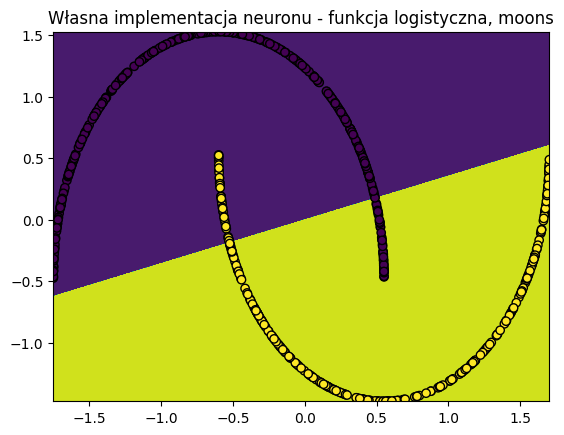

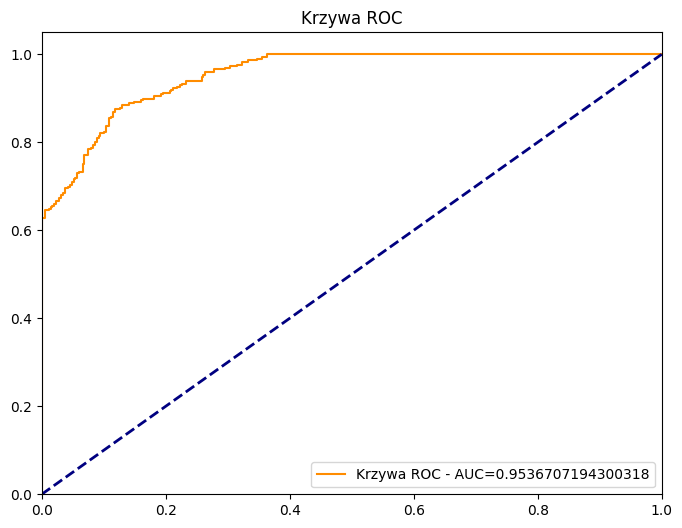

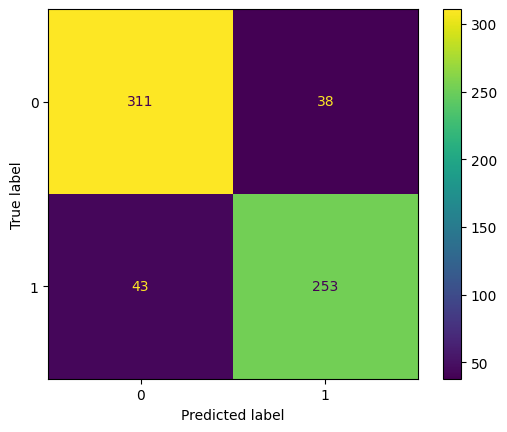

Czas uczenia 0.1113433837890625 s


In [ ]:
clf=Neuron()
start=time.time()
clf.fit(X_train_moons,y_train_moons)
end=time.time()-start
y_pred=clf.predict(X_test_moons)
y_score=clf.sigmoid(X_test_moons)
display_classifier_details(y_pred,y_test_moons,"Własna implementacja neuronu - funkcja logistyczna, moons")
plot_decision_boundary(X_test_moons,y_test_moons,clf,"Własna implementacja neuronu - funkcja logistyczna, moons")
plot_roc_curve(y_test_moons,y_score)
plot_confusion_matrix(y_test_moons,y_pred)

print(f"Czas uczenia {end} s")

#%%[markdown]

 # Własna implementacja neuronu dla minibatchy

	Własna implementacja neuronu, funkcja logistyczna, minibatche 

          	accuracy: 0.8666666666666667

          	sensitivity: 0.7978436657681941

          	specificity: 0.9598540145985401
        


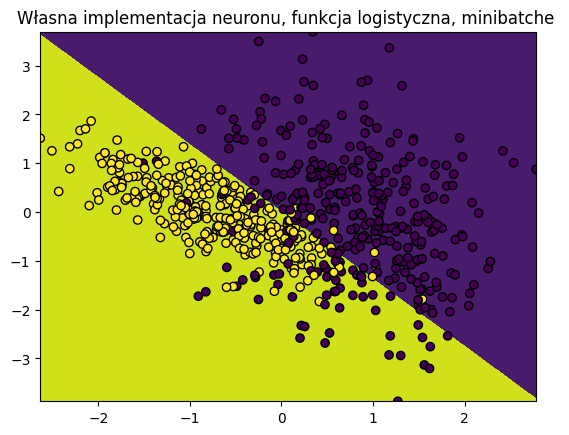

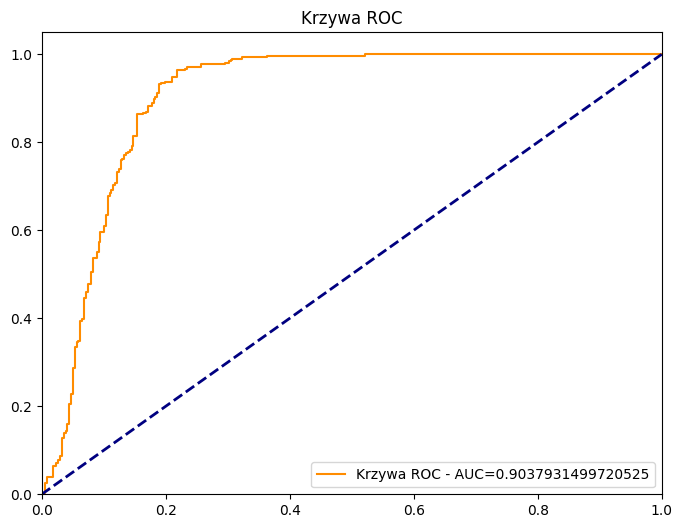

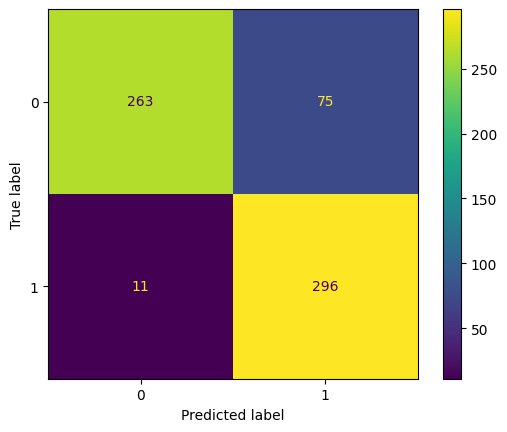

Czas uczenia 0.0750117301940918 s


In [ ]:
clf=Neuron(batch=True)
start=time.time()
clf.fit(X_train,y_train)
end=time.time()-start
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Własna implementacja neuronu, funkcja logistyczna, minibatche ")
plot_decision_boundary(X_test,y_test,clf,"Własna implementacja neuronu, funkcja logistyczna, minibatche ")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)

print(f"Czas uczenia {end} s")

#%%[markdown]

 # Neuron, moons z minibatchami
 # Własna implementacja neuronu dla minibatchy, moons

	Własna implementacja neuronu, funkcja logistyczna, minibatche, moons 

          	accuracy: 0.7441860465116279

          	sensitivity: 0.7220338983050848

          	specificity: 0.7628571428571429
        


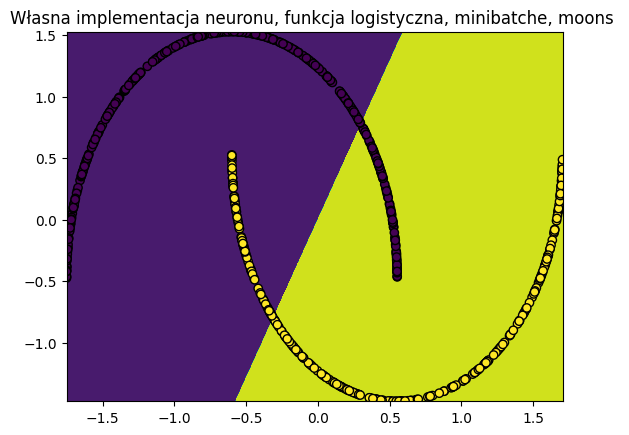

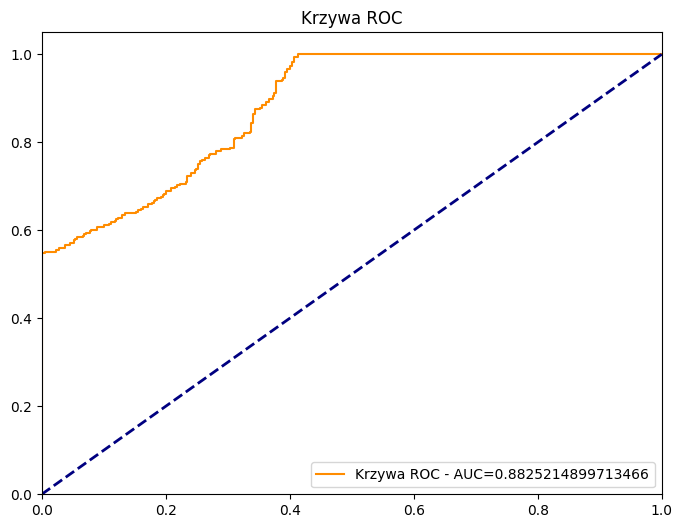

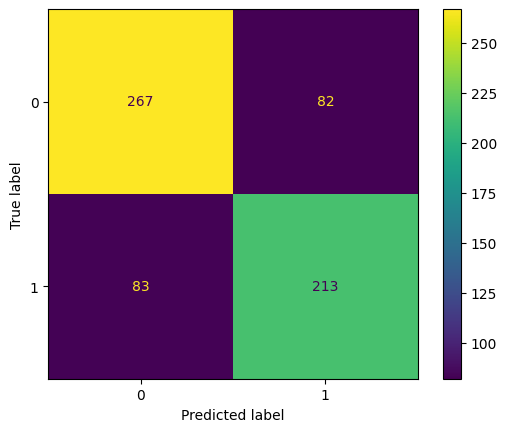

Czas uczenia 0.07621312141418457 s


In [ ]:
clf=Neuron(batch=True)
start=time.time()
clf.fit(X_train_moons,y_train_moons)
end=time.time()-start
y_pred=clf.predict(X_test_moons)
y_score=clf.sigmoid(X_test_moons)
display_classifier_details(y_pred,y_test_moons,"Własna implementacja neuronu, funkcja logistyczna, minibatche, moons ")
plot_decision_boundary(X_test_moons,y_test_moons,clf,"Własna implementacja neuronu, funkcja logistyczna, minibatche, moons ")
plot_roc_curve(y_test_moons,y_score)
plot_confusion_matrix(y_test_moons,y_pred)

print(f"Czas uczenia {end} s")

#%%[markdown]

 # Porównanie różnych funkcji aktywacji
 ## Tanh

	Neuron - tanh

          	accuracy: 0.8558139534883721

          	sensitivity: 0.8519736842105263

          	specificity: 0.8592375366568915
        


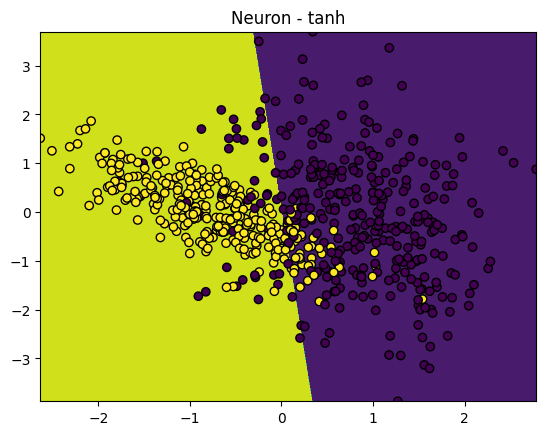

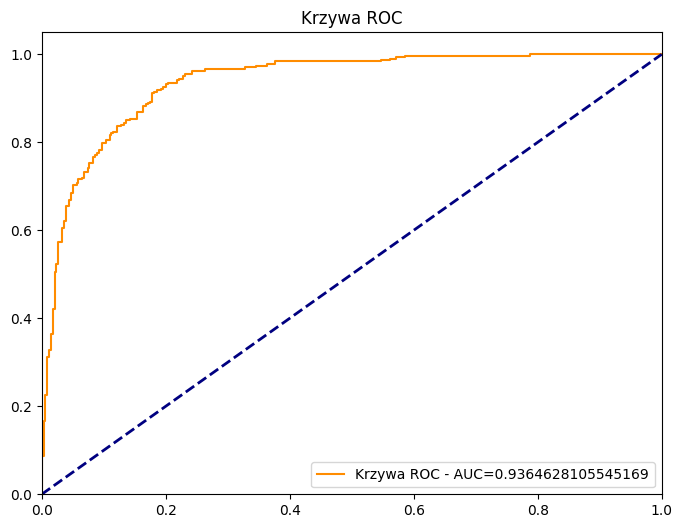

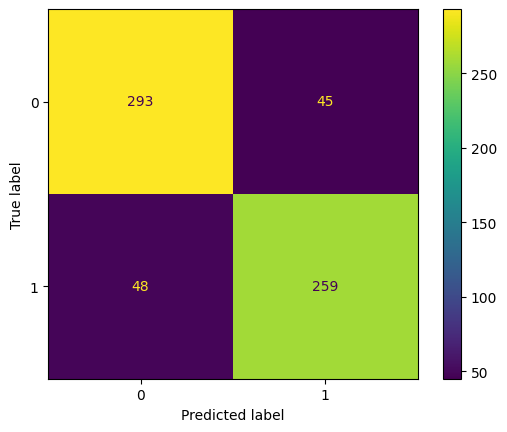

In [ ]:
clf=Neuron(type=ActivationFunction.TANH)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Neuron - tanh")
plot_decision_boundary(X_test,y_test,clf,"Neuron - tanh")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)

#%%[markdown]

 ## Relu

	Neuron - relu

          	accuracy: 0.8542635658914729

          	sensitivity: 0.8514851485148515

          	specificity: 0.8567251461988304
        


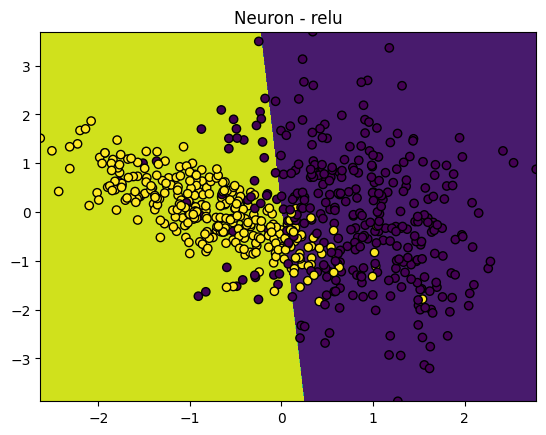

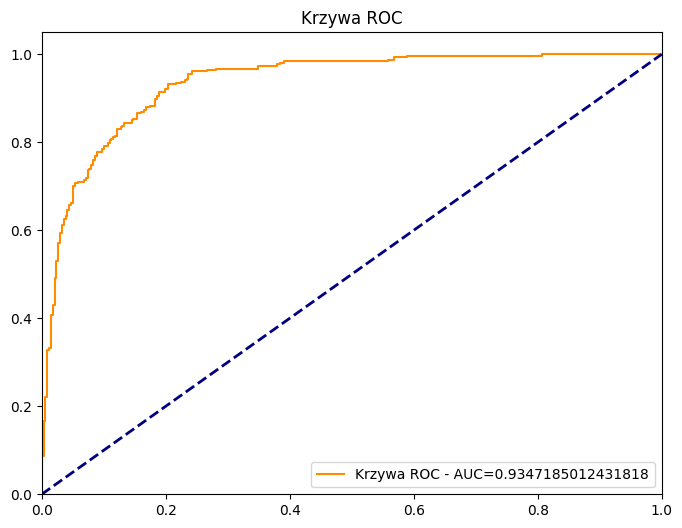

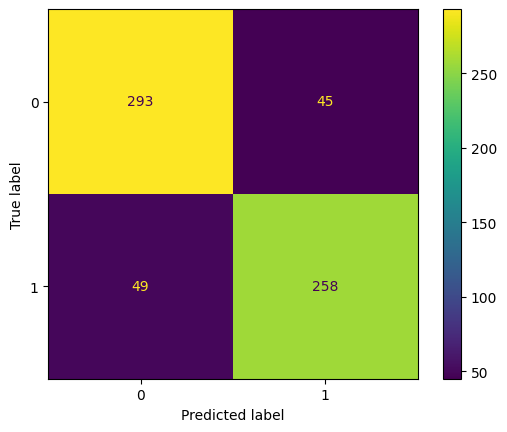

In [ ]:
clf=Neuron(type=ActivationFunction.RELU)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Neuron - relu")
plot_decision_boundary(X_test,y_test,clf,"Neuron - relu")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)

#%%[markdown]

 ## Relu leaky

	Neuron - leaky

          	accuracy: 0.8558139534883721

          	sensitivity: 0.8519736842105263

          	specificity: 0.8592375366568915
        


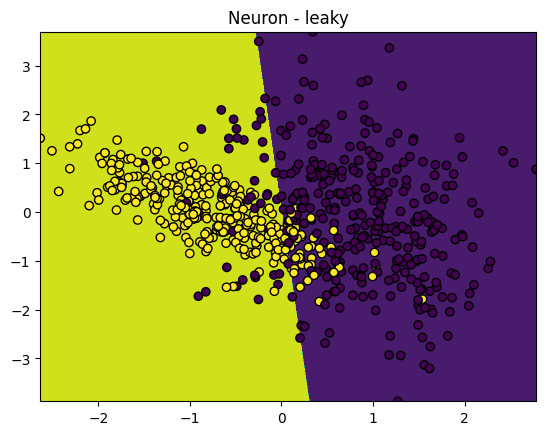

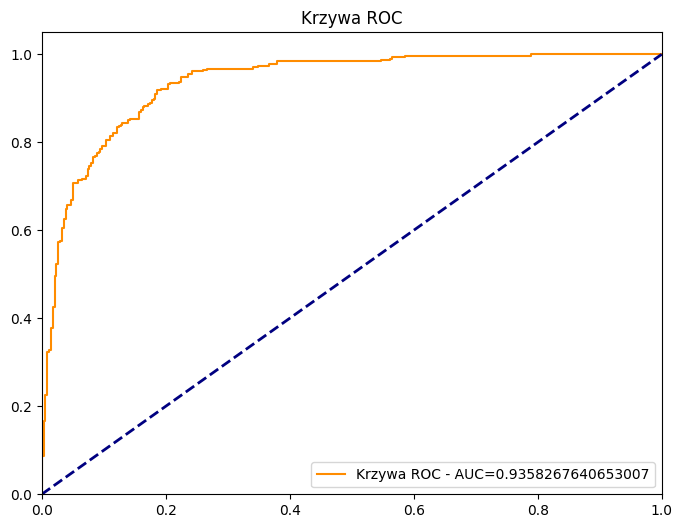

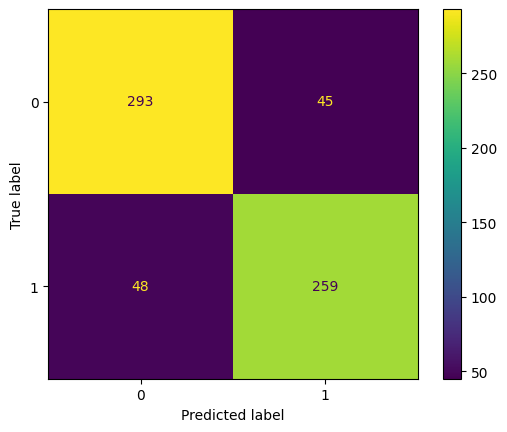

In [ ]:
clf=Neuron(type=ActivationFunction.LEAKY)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Neuron - leaky")
plot_decision_boundary(X_test,y_test,clf,"Neuron - leaky")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)

#%%[markdown]

 ## Heaviside

	Neuron - heaviside

          	accuracy: 0.8558139534883721

          	sensitivity: 0.8519736842105263

          	specificity: 0.8592375366568915
        


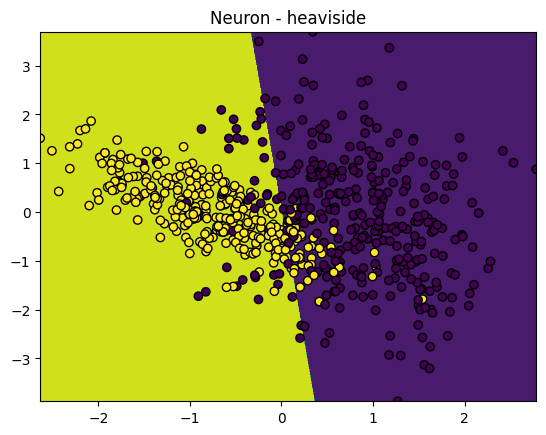

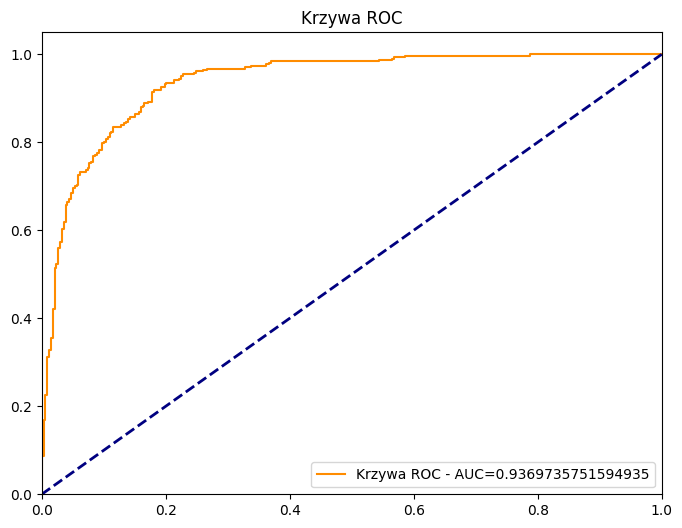

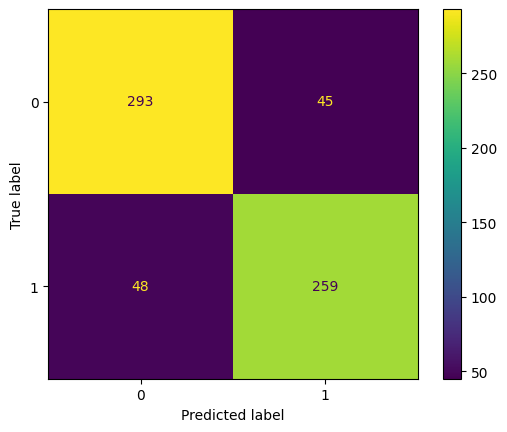

In [ ]:
clf=Neuron(type=ActivationFunction.HEAVISIDE)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Neuron - heaviside")
plot_decision_boundary(X_test,y_test,clf,"Neuron - heaviside")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)

#%%[markdown]

 ## Sign

	Neuron - sign

          	accuracy: 0.8558139534883721

          	sensitivity: 0.8519736842105263

          	specificity: 0.8592375366568915
        


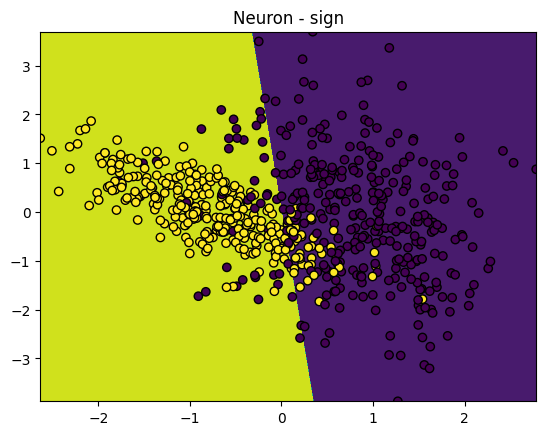

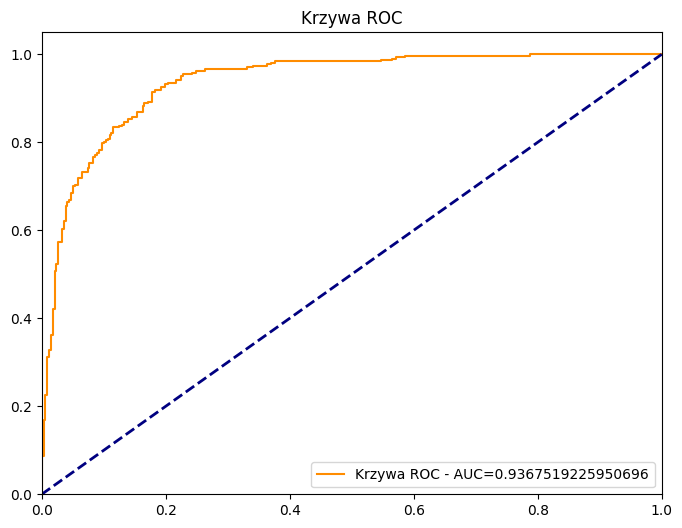

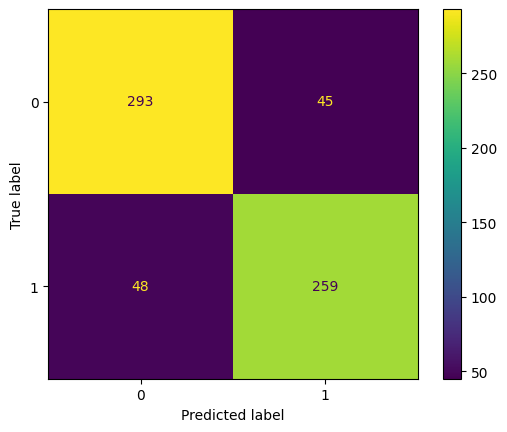

In [ ]:
clf=Neuron(type=ActivationFunction.SIGN)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Neuron - sign")
plot_decision_boundary(X_test,y_test,clf,"Neuron - sign")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)

#%%[markdown]

 ## Sin

	Neuron - sin

          	accuracy: 0.8604651162790697

          	sensitivity: 0.7862796833773087

          	specificity: 0.9661654135338346
        


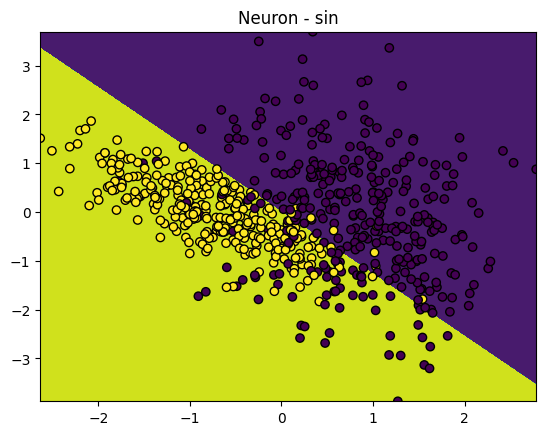

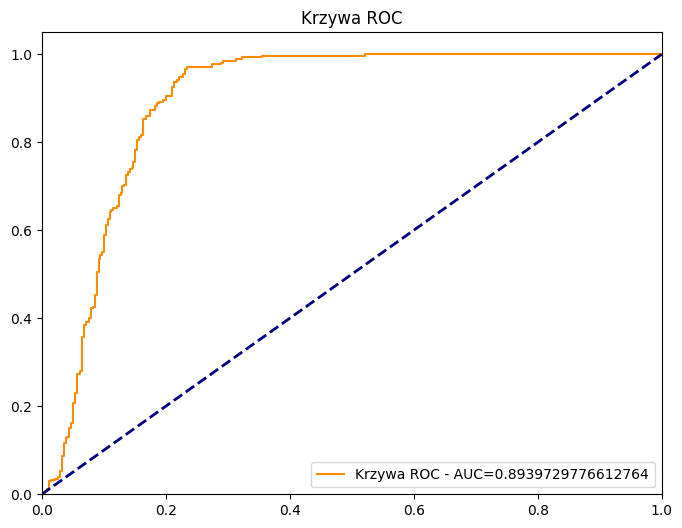

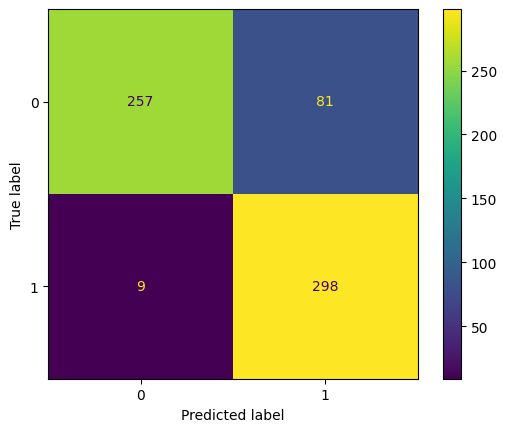

In [ ]:
clf=Neuron(type=ActivationFunction.SIN)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_score=clf.sigmoid(X_test)
display_classifier_details(y_pred,y_test,"Neuron - sin")
plot_decision_boundary(X_test,y_test,clf,"Neuron - sin")
plot_roc_curve(y_test,y_score)
plot_confusion_matrix(y_test,y_pred)